In [0]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Predicting Movie Review Sentiment with BERT on TF Hub

If you’ve been following Natural Language Processing over the past year, you’ve probably heard of BERT: Bidirectional Encoder Representations from Transformers. It’s a neural network architecture designed by Google researchers that’s totally transformed what’s state-of-the-art for NLP tasks, like text classification, translation, summarization, and question answering.

Now that BERT's been added to [TF Hub](https://www.tensorflow.org/hub) as a loadable module, it's easy(ish) to add into existing Tensorflow text pipelines. In an existing pipeline, BERT can replace text embedding layers like ELMO and GloVE. Alternatively, [finetuning](http://wiki.fast.ai/index.php/Fine_tuning) BERT can provide both an accuracy boost and faster training time in many cases.

Here, we'll train a model to predict whether an IMDB movie review is positive or negative using BERT in Tensorflow with tf hub. Some code was adapted from [this colab notebook](https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb). Let's get started!

In [1]:
%tensorflow_version 1.x
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

TensorFlow 1.x selected.


In addition to the standard libraries we imported above, we'll need to install BERT's python package.

In [2]:
!pip install bert-tensorflow

In [3]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

Below, we'll set an output directory location to store our model output and checkpoints. This can be a local directory, in which case you'd set OUTPUT_DIR to the name of the directory you'd like to create. If you're running this code in Google's hosted Colab, the directory won't persist after the Colab session ends.

Alternatively, if you're a GCP user, you can store output in a GCP bucket. To do that, set a directory name in OUTPUT_DIR and the name of the GCP bucket in the BUCKET field.

Set DO_DELETE to rewrite the OUTPUT_DIR if it exists. Otherwise, Tensorflow will load existing model checkpoints from that directory (if they exist).

In [6]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'OUTPUT_DIR_NAME'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = 'BUCKET_NAME' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: OUTPUT_DIR_NAME *****


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Data

First, let's download the dataset, hosted by Stanford. The code below, which downloads, extracts, and imports the IMDB Large Movie Review Dataset, is borrowed from [this Tensorflow tutorial](https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub).

In [0]:
data_train=pd.read_csv('/content/drive/My Drive/comp4332_Project1/data/train.csv')
data_val = pd.read_csv('/content/drive/My Drive/comp4332_Project1/data/valid.csv')
train = data_train[['stars' , 'text' , 'review_id']]
val = data_val[['stars' , 'text' , 'review_id']]

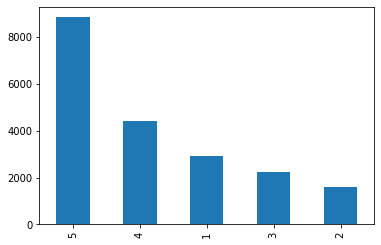

In [12]:
train['stars'].value_counts().plot(kind = 'bar')

In [67]:
val.head()

,stars,text,review_id
0,4,Food is sometimes sometimes great and somethin...,ewaMkuxfjfCX3ndtk0oRTw
1,5,They should seriously market the sausage and g...,SzkuvIpf0lcVaDgk5x2ipg
2,5,While I have had several average salon and spa...,ZGg6emL3sqhyyqHD_DJEag
3,5,I have been coming to NCS for almost two years...,IXYLmBVvRVFJZEhnhE_YsQ
4,3,"This place should be renamed to ""We Take Our S...",dao7SEXhBuMk7TieM4gEZA


To keep training fast, we'll take a sample of 5000 train and test examples, respectively.

For us, our input data is the 'sentence' column and our label is the 'polarity' column (0, 1 for negative and positive, respecitvely)

In [0]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'stars'
# label_list is the list of labels
label_list = [1, 2, 3, 4, 5]

#Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




To start, we'll need to load a vocabulary file and lowercasing information directly from the BERT tf hub module:

In [11]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Great--we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:

In [13]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands.

In [14]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 20000


INFO:tensorflow:Writing example 0 of 20000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] " what do you do for recreation ? " " oh , the usual . i bowl . drive around . the occasional acid flashback . " i do not actually like bowling . it ' s my nature . i only like things that i am good at and i am not even certain i would like to be good at bowling so i had my reservations when being invited to hang with the optimism club kids but i love these kids so . . . " fuck it , dude , let ' s go bowling . " i do have to admit ; i really had a blast here . it is vintage and sc ##um ##my on the outside which to me [SEP]


INFO:tensorflow:tokens: [CLS] " what do you do for recreation ? " " oh , the usual . i bowl . drive around . the occasional acid flashback . " i do not actually like bowling . it ' s my nature . i only like things that i am good at and i am not even certain i would like to be good at bowling so i had my reservations when being invited to hang with the optimism club kids but i love these kids so . . . " fuck it , dude , let ' s go bowling . " i do have to admit ; i really had a blast here . it is vintage and sc ##um ##my on the outside which to me [SEP]


INFO:tensorflow:input_ids: 101 1000 2054 2079 2017 2079 2005 8640 1029 1000 1000 2821 1010 1996 5156 1012 1045 4605 1012 3298 2105 1012 1996 8138 5648 21907 1012 1000 1045 2079 2025 2941 2066 9116 1012 2009 1005 1055 2026 3267 1012 1045 2069 2066 2477 2008 1045 2572 2204 2012 1998 1045 2572 2025 2130 3056 1045 2052 2066 2000 2022 2204 2012 9116 2061 1045 2018 2026 17829 2043 2108 4778 2000 6865 2007 1996 27451 2252 4268 2021 1045 2293 2122 4268 2061 1012 1012 1012 1000 6616 2009 1010 12043 1010 2292 1005 1055 2175 9116 1012 1000 1045 2079 2031 2000 6449 1025 1045 2428 2018 1037 8479 2182 1012 2009 2003 13528 1998 8040 2819 8029 2006 1996 2648 2029 2000 2033 102


INFO:tensorflow:input_ids: 101 1000 2054 2079 2017 2079 2005 8640 1029 1000 1000 2821 1010 1996 5156 1012 1045 4605 1012 3298 2105 1012 1996 8138 5648 21907 1012 1000 1045 2079 2025 2941 2066 9116 1012 2009 1005 1055 2026 3267 1012 1045 2069 2066 2477 2008 1045 2572 2204 2012 1998 1045 2572 2025 2130 3056 1045 2052 2066 2000 2022 2204 2012 9116 2061 1045 2018 2026 17829 2043 2108 4778 2000 6865 2007 1996 27451 2252 4268 2021 1045 2293 2122 4268 2061 1012 1012 1012 1000 6616 2009 1010 12043 1010 2292 1005 1055 2175 9116 1012 1000 1045 2079 2031 2000 6449 1025 1045 2428 2018 1037 8479 2182 1012 2009 2003 13528 1998 8040 2819 8029 2006 1996 2648 2029 2000 2033 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 3)


INFO:tensorflow:label: 4 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the burger ##s are good and they have good fries too . i used to get the ib ##ion rings but i can ' t eat onion now unfortunately . would recommend to anyone for lunch . [SEP]


INFO:tensorflow:tokens: [CLS] the burger ##s are good and they have good fries too . i used to get the ib ##ion rings but i can ' t eat onion now unfortunately . would recommend to anyone for lunch . [SEP]


INFO:tensorflow:input_ids: 101 1996 15890 2015 2024 2204 1998 2027 2031 2204 22201 2205 1012 1045 2109 2000 2131 1996 21307 3258 7635 2021 1045 2064 1005 1056 4521 20949 2085 6854 1012 2052 16755 2000 3087 2005 6265 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 15890 2015 2024 2204 1998 2027 2031 2204 22201 2205 1012 1045 2109 2000 2131 1996 21307 3258 7635 2021 1045 2064 1005 1056 4521 20949 2085 6854 1012 2052 16755 2000 3087 2005 6265 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] been there three times , twice they didn ' t have gu ##aca ##mo ##le . took the family on thursday night to hear live reggae , which they had confirmed when i called earlier in the day . ordered gu ##ac . . . no gu ##ac . ordered beef with mole . . . we ' re out of mole . wife ordered car ##ni ##tas , after long wait , waitress came back and informed her they were out of car ##ni ##tas . i think any problems relate to lai ##sse ##z fair ##e management . service is slow because they don ' t pay for enough staff . food takes long b / c there is only room for one cook [SEP]


INFO:tensorflow:tokens: [CLS] been there three times , twice they didn ' t have gu ##aca ##mo ##le . took the family on thursday night to hear live reggae , which they had confirmed when i called earlier in the day . ordered gu ##ac . . . no gu ##ac . ordered beef with mole . . . we ' re out of mole . wife ordered car ##ni ##tas , after long wait , waitress came back and informed her they were out of car ##ni ##tas . i think any problems relate to lai ##sse ##z fair ##e management . service is slow because they don ' t pay for enough staff . food takes long b / c there is only room for one cook [SEP]


INFO:tensorflow:input_ids: 101 2042 2045 2093 2335 1010 3807 2027 2134 1005 1056 2031 19739 19629 5302 2571 1012 2165 1996 2155 2006 9432 2305 2000 2963 2444 15662 1010 2029 2027 2018 4484 2043 1045 2170 3041 1999 1996 2154 1012 3641 19739 6305 1012 1012 1012 2053 19739 6305 1012 3641 12486 2007 16709 1012 1012 1012 2057 1005 2128 2041 1997 16709 1012 2564 3641 2482 3490 10230 1010 2044 2146 3524 1010 13877 2234 2067 1998 6727 2014 2027 2020 2041 1997 2482 3490 10230 1012 1045 2228 2151 3471 14396 2000 21110 11393 2480 4189 2063 2968 1012 2326 2003 4030 2138 2027 2123 1005 1056 3477 2005 2438 3095 1012 2833 3138 2146 1038 1013 1039 2045 2003 2069 2282 2005 2028 5660 102


INFO:tensorflow:input_ids: 101 2042 2045 2093 2335 1010 3807 2027 2134 1005 1056 2031 19739 19629 5302 2571 1012 2165 1996 2155 2006 9432 2305 2000 2963 2444 15662 1010 2029 2027 2018 4484 2043 1045 2170 3041 1999 1996 2154 1012 3641 19739 6305 1012 1012 1012 2053 19739 6305 1012 3641 12486 2007 16709 1012 1012 1012 2057 1005 2128 2041 1997 16709 1012 2564 3641 2482 3490 10230 1010 2044 2146 3524 1010 13877 2234 2067 1998 6727 2014 2027 2020 2041 1997 2482 3490 10230 1012 1045 2228 2151 3471 14396 2000 21110 11393 2480 4189 2063 2968 1012 2326 2003 4030 2138 2027 2123 1005 1056 3477 2005 2438 3095 1012 2833 3138 2146 1038 1013 1039 2045 2003 2069 2282 2005 2028 5660 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 1)


INFO:tensorflow:label: 2 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] pretty excited to discover this cal ##i gas ##tro ##pu ##b was arriving at the swan ##ky downtown summer ##lin . great beers and our server was not only fun but extremely knowledge ##able and turned me on to the w ##him ##sic ##al and ta ##sty golden monkey . outdoor patio is great place for a late night meal . and best of al locals get half off their bill on mondays . how good is that ? [SEP]


INFO:tensorflow:tokens: [CLS] pretty excited to discover this cal ##i gas ##tro ##pu ##b was arriving at the swan ##ky downtown summer ##lin . great beers and our server was not only fun but extremely knowledge ##able and turned me on to the w ##him ##sic ##al and ta ##sty golden monkey . outdoor patio is great place for a late night meal . and best of al locals get half off their bill on mondays . how good is that ? [SEP]


INFO:tensorflow:input_ids: 101 3492 7568 2000 7523 2023 10250 2072 3806 13181 14289 2497 2001 7194 2012 1996 10677 4801 5116 2621 4115 1012 2307 18007 1998 2256 8241 2001 2025 2069 4569 2021 5186 3716 3085 1998 2357 2033 2006 2000 1996 1059 14341 19570 2389 1998 11937 21756 3585 10608 1012 7254 19404 2003 2307 2173 2005 1037 2397 2305 7954 1012 1998 2190 1997 2632 10575 2131 2431 2125 2037 3021 2006 28401 1012 2129 2204 2003 2008 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3492 7568 2000 7523 2023 10250 2072 3806 13181 14289 2497 2001 7194 2012 1996 10677 4801 5116 2621 4115 1012 2307 18007 1998 2256 8241 2001 2025 2069 4569 2021 5186 3716 3085 1998 2357 2033 2006 2000 1996 1059 14341 19570 2389 1998 11937 21756 3585 10608 1012 7254 19404 2003 2307 2173 2005 1037 2397 2305 7954 1012 1998 2190 1997 2632 10575 2131 2431 2125 2037 3021 2006 28401 1012 2129 2204 2003 2008 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i have been very pleased with the care that i receive here . i have been going to them since 2002 for five different reasons and i love them . they are thorough , caring and very dedicated to see you recover completely . their front office staff is amazing . they will work with you to assure that you are getting everything you need and make sure that your insurance and referring physician are informed about your care . i have had pablo and cory as my therapist and i would recommend them to anyone that needs physical therapy . [SEP]


INFO:tensorflow:tokens: [CLS] i have been very pleased with the care that i receive here . i have been going to them since 2002 for five different reasons and i love them . they are thorough , caring and very dedicated to see you recover completely . their front office staff is amazing . they will work with you to assure that you are getting everything you need and make sure that your insurance and referring physician are informed about your care . i have had pablo and cory as my therapist and i would recommend them to anyone that needs physical therapy . [SEP]


INFO:tensorflow:input_ids: 101 1045 2031 2042 2200 7537 2007 1996 2729 2008 1045 4374 2182 1012 1045 2031 2042 2183 2000 2068 2144 2526 2005 2274 2367 4436 1998 1045 2293 2068 1012 2027 2024 16030 1010 11922 1998 2200 4056 2000 2156 2017 8980 3294 1012 2037 2392 2436 3095 2003 6429 1012 2027 2097 2147 2007 2017 2000 14306 2008 2017 2024 2893 2673 2017 2342 1998 2191 2469 2008 2115 5427 1998 7727 7522 2024 6727 2055 2115 2729 1012 1045 2031 2018 11623 1998 18342 2004 2026 19294 1998 1045 2052 16755 2068 2000 3087 2008 3791 3558 7242 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2031 2042 2200 7537 2007 1996 2729 2008 1045 4374 2182 1012 1045 2031 2042 2183 2000 2068 2144 2526 2005 2274 2367 4436 1998 1045 2293 2068 1012 2027 2024 16030 1010 11922 1998 2200 4056 2000 2156 2017 8980 3294 1012 2037 2392 2436 3095 2003 6429 1012 2027 2097 2147 2007 2017 2000 14306 2008 2017 2024 2893 2673 2017 2342 1998 2191 2469 2008 2115 5427 1998 7727 7522 2024 6727 2055 2115 2729 1012 1045 2031 2018 11623 1998 18342 2004 2026 19294 1998 1045 2052 16755 2068 2000 3087 2008 3791 3558 7242 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:Writing example 10000 of 20000


INFO:tensorflow:Writing example 10000 of 20000


INFO:tensorflow:Writing example 0 of 2000


INFO:tensorflow:Writing example 0 of 2000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] food is sometimes sometimes great and something ##s just good . wasn ' t a fan of their br ##un ##ch but lunch and dinner is good . service is hit and miss . [SEP]


INFO:tensorflow:tokens: [CLS] food is sometimes sometimes great and something ##s just good . wasn ' t a fan of their br ##un ##ch but lunch and dinner is good . service is hit and miss . [SEP]


INFO:tensorflow:input_ids: 101 2833 2003 2823 2823 2307 1998 2242 2015 2074 2204 1012 2347 1005 1056 1037 5470 1997 2037 7987 4609 2818 2021 6265 1998 4596 2003 2204 1012 2326 2003 2718 1998 3335 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2833 2003 2823 2823 2307 1998 2242 2015 2074 2204 1012 2347 1005 1056 1037 5470 1997 2037 7987 4609 2818 2021 6265 1998 4596 2003 2204 1012 2326 2003 2718 1998 3335 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 3)


INFO:tensorflow:label: 4 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] they should seriously market the sausage and gr ##av ##y . you may hear chicken sausage but - good lord this is some amazing sausage biscuits and gr ##av ##y . [SEP]


INFO:tensorflow:tokens: [CLS] they should seriously market the sausage and gr ##av ##y . you may hear chicken sausage but - good lord this is some amazing sausage biscuits and gr ##av ##y . [SEP]


INFO:tensorflow:input_ids: 101 2027 2323 5667 3006 1996 24165 1998 24665 11431 2100 1012 2017 2089 2963 7975 24165 2021 1011 2204 2935 2023 2003 2070 6429 24165 27529 1998 24665 11431 2100 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2027 2323 5667 3006 1996 24165 1998 24665 11431 2100 1012 2017 2089 2963 7975 24165 2021 1011 2204 2935 2023 2003 2070 6429 24165 27529 1998 24665 11431 2100 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] while i have had several average salon and spa services at holt ##s this review is for my hair coloring experiences with ina . i have had my blonde highlights done by ina on and off for a few years . i was always very happy with the results , yet i was kept trying to look for a more reasonably priced place because it is very expensive indeed ( in my case about $ 300 with the tone ##r and blow dry , which is not included ) . and so it was that a month before my wedding i went to a very rep ##utable downtown salon ( supposedly the best in to ) to have my highlights done . to make a very [SEP]


INFO:tensorflow:tokens: [CLS] while i have had several average salon and spa services at holt ##s this review is for my hair coloring experiences with ina . i have had my blonde highlights done by ina on and off for a few years . i was always very happy with the results , yet i was kept trying to look for a more reasonably priced place because it is very expensive indeed ( in my case about $ 300 with the tone ##r and blow dry , which is not included ) . and so it was that a month before my wedding i went to a very rep ##utable downtown salon ( supposedly the best in to ) to have my highlights done . to make a very [SEP]


INFO:tensorflow:input_ids: 101 2096 1045 2031 2018 2195 2779 11090 1998 12403 2578 2012 12621 2015 2023 3319 2003 2005 2026 2606 22276 6322 2007 27118 1012 1045 2031 2018 2026 9081 11637 2589 2011 27118 2006 1998 2125 2005 1037 2261 2086 1012 1045 2001 2467 2200 3407 2007 1996 3463 1010 2664 1045 2001 2921 2667 2000 2298 2005 1037 2062 16286 21125 2173 2138 2009 2003 2200 6450 5262 1006 1999 2026 2553 2055 1002 3998 2007 1996 4309 2099 1998 6271 4318 1010 2029 2003 2025 2443 1007 1012 1998 2061 2009 2001 2008 1037 3204 2077 2026 5030 1045 2253 2000 1037 2200 16360 23056 5116 11090 1006 10743 1996 2190 1999 2000 1007 2000 2031 2026 11637 2589 1012 2000 2191 1037 2200 102


INFO:tensorflow:input_ids: 101 2096 1045 2031 2018 2195 2779 11090 1998 12403 2578 2012 12621 2015 2023 3319 2003 2005 2026 2606 22276 6322 2007 27118 1012 1045 2031 2018 2026 9081 11637 2589 2011 27118 2006 1998 2125 2005 1037 2261 2086 1012 1045 2001 2467 2200 3407 2007 1996 3463 1010 2664 1045 2001 2921 2667 2000 2298 2005 1037 2062 16286 21125 2173 2138 2009 2003 2200 6450 5262 1006 1999 2026 2553 2055 1002 3998 2007 1996 4309 2099 1998 6271 4318 1010 2029 2003 2025 2443 1007 1012 1998 2061 2009 2001 2008 1037 3204 2077 2026 5030 1045 2253 2000 1037 2200 16360 23056 5116 11090 1006 10743 1996 2190 1999 2000 1007 2000 2031 2026 11637 2589 1012 2000 2191 1037 2200 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i have been coming to nc ##s for almost two years . i had been going to a salon in the mall for about a year and i noticed that my hair was getting extremely dry . i used some products that they recommended but nothing seemed to help . a friend recommended sara d so i made an appointment with her hoping that she would be able to make some suggestions for my dry and damaged hair . she suggested one product and gave me tips for drying and styling that would help . since that first visit , my hair has come along way . sara always gives me suggestions for keeping my hair healthy and she ' ll recommend different products in the [SEP]


INFO:tensorflow:tokens: [CLS] i have been coming to nc ##s for almost two years . i had been going to a salon in the mall for about a year and i noticed that my hair was getting extremely dry . i used some products that they recommended but nothing seemed to help . a friend recommended sara d so i made an appointment with her hoping that she would be able to make some suggestions for my dry and damaged hair . she suggested one product and gave me tips for drying and styling that would help . since that first visit , my hair has come along way . sara always gives me suggestions for keeping my hair healthy and she ' ll recommend different products in the [SEP]


INFO:tensorflow:input_ids: 101 1045 2031 2042 2746 2000 13316 2015 2005 2471 2048 2086 1012 1045 2018 2042 2183 2000 1037 11090 1999 1996 6670 2005 2055 1037 2095 1998 1045 4384 2008 2026 2606 2001 2893 5186 4318 1012 1045 2109 2070 3688 2008 2027 6749 2021 2498 2790 2000 2393 1012 1037 2767 6749 7354 1040 2061 1045 2081 2019 6098 2007 2014 5327 2008 2016 2052 2022 2583 2000 2191 2070 15690 2005 2026 4318 1998 5591 2606 1012 2016 4081 2028 4031 1998 2435 2033 10247 2005 17462 1998 20724 2008 2052 2393 1012 2144 2008 2034 3942 1010 2026 2606 2038 2272 2247 2126 1012 7354 2467 3957 2033 15690 2005 4363 2026 2606 7965 1998 2016 1005 2222 16755 2367 3688 1999 1996 102


INFO:tensorflow:input_ids: 101 1045 2031 2042 2746 2000 13316 2015 2005 2471 2048 2086 1012 1045 2018 2042 2183 2000 1037 11090 1999 1996 6670 2005 2055 1037 2095 1998 1045 4384 2008 2026 2606 2001 2893 5186 4318 1012 1045 2109 2070 3688 2008 2027 6749 2021 2498 2790 2000 2393 1012 1037 2767 6749 7354 1040 2061 1045 2081 2019 6098 2007 2014 5327 2008 2016 2052 2022 2583 2000 2191 2070 15690 2005 2026 4318 1998 5591 2606 1012 2016 4081 2028 4031 1998 2435 2033 10247 2005 17462 1998 20724 2008 2052 2393 1012 2144 2008 2034 3942 1010 2026 2606 2038 2272 2247 2126 1012 7354 2467 3957 2033 15690 2005 4363 2026 2606 7965 1998 2016 1005 2222 16755 2367 3688 1999 1996 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:label: 5 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this place should be renamed to " we take our sweet ass time " large fried chicken . j ##ks , but seriously . there was no line , and only 3 people waiting in front of me for their order , and it still took a good 15 minutes to receive my order . i ordered the regular chicken w / the strawberry drink ( forgot what it ' s called ) . the chicken was pretty good , i must admit . the drink , however , was decent - tasted like strawberry sp ##rite - but not worth ~ $ 3 . 50 . come here only if you have time to spare . [SEP]


INFO:tensorflow:tokens: [CLS] this place should be renamed to " we take our sweet ass time " large fried chicken . j ##ks , but seriously . there was no line , and only 3 people waiting in front of me for their order , and it still took a good 15 minutes to receive my order . i ordered the regular chicken w / the strawberry drink ( forgot what it ' s called ) . the chicken was pretty good , i must admit . the drink , however , was decent - tasted like strawberry sp ##rite - but not worth ~ $ 3 . 50 . come here only if you have time to spare . [SEP]


INFO:tensorflow:input_ids: 101 2023 2173 2323 2022 4096 2000 1000 2057 2202 2256 4086 4632 2051 1000 2312 13017 7975 1012 1046 5705 1010 2021 5667 1012 2045 2001 2053 2240 1010 1998 2069 1017 2111 3403 1999 2392 1997 2033 2005 2037 2344 1010 1998 2009 2145 2165 1037 2204 2321 2781 2000 4374 2026 2344 1012 1045 3641 1996 3180 7975 1059 1013 1996 16876 4392 1006 9471 2054 2009 1005 1055 2170 1007 1012 1996 7975 2001 3492 2204 1010 1045 2442 6449 1012 1996 4392 1010 2174 1010 2001 11519 1011 12595 2066 16876 11867 17625 1011 2021 2025 4276 1066 1002 1017 1012 2753 1012 2272 2182 2069 2065 2017 2031 2051 2000 8622 1012 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2023 2173 2323 2022 4096 2000 1000 2057 2202 2256 4086 4632 2051 1000 2312 13017 7975 1012 1046 5705 1010 2021 5667 1012 2045 2001 2053 2240 1010 1998 2069 1017 2111 3403 1999 2392 1997 2033 2005 2037 2344 1010 1998 2009 2145 2165 1037 2204 2321 2781 2000 4374 2026 2344 1012 1045 3641 1996 3180 7975 1059 1013 1996 16876 4392 1006 9471 2054 2009 1005 1055 2170 1007 1012 1996 7975 2001 3492 2204 1010 1045 2442 6449 1012 1996 4392 1010 2174 1010 2001 11519 1011 12595 2066 16876 11867 17625 1011 2021 2025 4276 1066 1002 1017 1012 2753 1012 2272 2182 2069 2065 2017 2031 2051 2000 8622 1012 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 2)


INFO:tensorflow:label: 3 (id = 2)


#Creating a model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our sentiment task (i.e. classifying whether a movie review is positive or negative). This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction.

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        '''
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        '''
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            '''
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            '''
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [0]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 2.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [0]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [21]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'OUTPUT_DIR_NAME', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff15c8df940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'OUTPUT_DIR_NAME', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff15c8df940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

Now we train our model! For me, using a Colab notebook running on Google's GPUs, my training time was about 14 minutes.

In [23]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into OUTPUT_DIR_NAME/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into OUTPUT_DIR_NAME/model.ckpt.


INFO:tensorflow:loss = 1.6400478, step = 0


INFO:tensorflow:loss = 1.6400478, step = 0


INFO:tensorflow:global_step/sec: 1.06552


INFO:tensorflow:global_step/sec: 1.06552


INFO:tensorflow:loss = 0.74394643, step = 100 (93.852 sec)


INFO:tensorflow:loss = 0.74394643, step = 100 (93.852 sec)


INFO:tensorflow:global_step/sec: 1.19902


INFO:tensorflow:global_step/sec: 1.19902


INFO:tensorflow:loss = 0.9595437, step = 200 (83.402 sec)


INFO:tensorflow:loss = 0.9595437, step = 200 (83.402 sec)


INFO:tensorflow:global_step/sec: 1.1807


INFO:tensorflow:global_step/sec: 1.1807


INFO:tensorflow:loss = 0.84854984, step = 300 (84.695 sec)


INFO:tensorflow:loss = 0.84854984, step = 300 (84.695 sec)


INFO:tensorflow:global_step/sec: 1.17504


INFO:tensorflow:global_step/sec: 1.17504


INFO:tensorflow:loss = 0.6457206, step = 400 (85.104 sec)


INFO:tensorflow:loss = 0.6457206, step = 400 (85.104 sec)


INFO:tensorflow:Saving checkpoints for 500 into OUTPUT_DIR_NAME/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into OUTPUT_DIR_NAME/model.ckpt.


INFO:tensorflow:global_step/sec: 1.09439


INFO:tensorflow:global_step/sec: 1.09439


INFO:tensorflow:loss = 0.60139203, step = 500 (91.380 sec)


INFO:tensorflow:loss = 0.60139203, step = 500 (91.380 sec)


INFO:tensorflow:global_step/sec: 1.17287


INFO:tensorflow:global_step/sec: 1.17287


INFO:tensorflow:loss = 0.83074844, step = 600 (85.256 sec)


INFO:tensorflow:loss = 0.83074844, step = 600 (85.256 sec)


INFO:tensorflow:global_step/sec: 1.16838


INFO:tensorflow:global_step/sec: 1.16838


INFO:tensorflow:loss = 0.77076805, step = 700 (85.593 sec)


INFO:tensorflow:loss = 0.77076805, step = 700 (85.593 sec)


INFO:tensorflow:global_step/sec: 1.165


INFO:tensorflow:global_step/sec: 1.165


INFO:tensorflow:loss = 0.43521738, step = 800 (85.833 sec)


INFO:tensorflow:loss = 0.43521738, step = 800 (85.833 sec)


INFO:tensorflow:global_step/sec: 1.16552


INFO:tensorflow:global_step/sec: 1.16552


INFO:tensorflow:loss = 0.6175382, step = 900 (85.800 sec)


INFO:tensorflow:loss = 0.6175382, step = 900 (85.800 sec)


INFO:tensorflow:Saving checkpoints for 1000 into OUTPUT_DIR_NAME/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into OUTPUT_DIR_NAME/model.ckpt.


INFO:tensorflow:global_step/sec: 1.09102


INFO:tensorflow:global_step/sec: 1.09102


INFO:tensorflow:loss = 0.8510931, step = 1000 (91.655 sec)


INFO:tensorflow:loss = 0.8510931, step = 1000 (91.655 sec)


INFO:tensorflow:global_step/sec: 1.17258


INFO:tensorflow:global_step/sec: 1.17258


INFO:tensorflow:loss = 0.6240107, step = 1100 (85.286 sec)


INFO:tensorflow:loss = 0.6240107, step = 1100 (85.286 sec)


INFO:tensorflow:global_step/sec: 1.16861


INFO:tensorflow:global_step/sec: 1.16861


INFO:tensorflow:loss = 0.54200184, step = 1200 (85.568 sec)


INFO:tensorflow:loss = 0.54200184, step = 1200 (85.568 sec)


INFO:tensorflow:Saving checkpoints for 1250 into OUTPUT_DIR_NAME/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1250 into OUTPUT_DIR_NAME/model.ckpt.


INFO:tensorflow:Loss for final step: 0.58162963.


INFO:tensorflow:Loss for final step: 0.58162963.


Training took time  0:19:05.989914


Now let's use our test data to see how well our model did:

In [0]:
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [25]:
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-04-16T11:45:56Z


INFO:tensorflow:Starting evaluation at 2020-04-16T11:45:56Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME/model.ckpt-1250


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME/model.ckpt-1250


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-04-16-11:46:19


INFO:tensorflow:Finished evaluation at 2020-04-16-11:46:19


INFO:tensorflow:Saving dict for global step 1250: 
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            true_positives = 1611.0, eval_accuracy = 0.688, false_negatives = 74.0, false_positives = 63.0, global_step = 1250, loss = 0.7987433, true_negatives = 252.0


INFO:tensorflow:Saving dict for global step 1250: 
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            true_positives = 1611.0, eval_accuracy = 0.688, false_negatives = 74.0, false_positives = 63.0, global_step = 1250, loss = 0.7987433, true_negatives = 252.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1250: OUTPUT_DIR_NAME/model.ckpt-1250


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1250: OUTPUT_DIR_NAME/model.ckpt-1250


{'\n            "f1_score": f1_score,\n            "auc": auc,\n            "precision": precision,\n            "recall": recall,\n            true_positives': 1611.0,
 'eval_accuracy': 0.688,
 'false_negatives': 74.0,
 'false_positives': 63.0,
 'global_step': 1250,
 'loss': 0.7987433,
 'true_negatives': 252.0}

Now let's write code to make predictions on new sentences:

In [0]:
def getPrediction(in_sentences):
  labels = [1, 2, 3, 4, 5]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 1) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [0]:
pred_sentences = list(val['text'])

In [70]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 2000


INFO:tensorflow:Writing example 0 of 2000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] food is sometimes sometimes great and something ##s just good . wasn ' t a fan of their br ##un ##ch but lunch and dinner is good . service is hit and miss . [SEP]


INFO:tensorflow:tokens: [CLS] food is sometimes sometimes great and something ##s just good . wasn ' t a fan of their br ##un ##ch but lunch and dinner is good . service is hit and miss . [SEP]


INFO:tensorflow:input_ids: 101 2833 2003 2823 2823 2307 1998 2242 2015 2074 2204 1012 2347 1005 1056 1037 5470 1997 2037 7987 4609 2818 2021 6265 1998 4596 2003 2204 1012 2326 2003 2718 1998 3335 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2833 2003 2823 2823 2307 1998 2242 2015 2074 2204 1012 2347 1005 1056 1037 5470 1997 2037 7987 4609 2818 2021 6265 1998 4596 2003 2204 1012 2326 2003 2718 1998 3335 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] they should seriously market the sausage and gr ##av ##y . you may hear chicken sausage but - good lord this is some amazing sausage biscuits and gr ##av ##y . [SEP]


INFO:tensorflow:tokens: [CLS] they should seriously market the sausage and gr ##av ##y . you may hear chicken sausage but - good lord this is some amazing sausage biscuits and gr ##av ##y . [SEP]


INFO:tensorflow:input_ids: 101 2027 2323 5667 3006 1996 24165 1998 24665 11431 2100 1012 2017 2089 2963 7975 24165 2021 1011 2204 2935 2023 2003 2070 6429 24165 27529 1998 24665 11431 2100 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2027 2323 5667 3006 1996 24165 1998 24665 11431 2100 1012 2017 2089 2963 7975 24165 2021 1011 2204 2935 2023 2003 2070 6429 24165 27529 1998 24665 11431 2100 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] while i have had several average salon and spa services at holt ##s this review is for my hair coloring experiences with ina . i have had my blonde highlights done by ina on and off for a few years . i was always very happy with the results , yet i was kept trying to look for a more reasonably priced place because it is very expensive indeed ( in my case about $ 300 with the tone ##r and blow dry , which is not included ) . and so it was that a month before my wedding i went to a very rep ##utable downtown salon ( supposedly the best in to ) to have my highlights done . to make a very [SEP]


INFO:tensorflow:tokens: [CLS] while i have had several average salon and spa services at holt ##s this review is for my hair coloring experiences with ina . i have had my blonde highlights done by ina on and off for a few years . i was always very happy with the results , yet i was kept trying to look for a more reasonably priced place because it is very expensive indeed ( in my case about $ 300 with the tone ##r and blow dry , which is not included ) . and so it was that a month before my wedding i went to a very rep ##utable downtown salon ( supposedly the best in to ) to have my highlights done . to make a very [SEP]


INFO:tensorflow:input_ids: 101 2096 1045 2031 2018 2195 2779 11090 1998 12403 2578 2012 12621 2015 2023 3319 2003 2005 2026 2606 22276 6322 2007 27118 1012 1045 2031 2018 2026 9081 11637 2589 2011 27118 2006 1998 2125 2005 1037 2261 2086 1012 1045 2001 2467 2200 3407 2007 1996 3463 1010 2664 1045 2001 2921 2667 2000 2298 2005 1037 2062 16286 21125 2173 2138 2009 2003 2200 6450 5262 1006 1999 2026 2553 2055 1002 3998 2007 1996 4309 2099 1998 6271 4318 1010 2029 2003 2025 2443 1007 1012 1998 2061 2009 2001 2008 1037 3204 2077 2026 5030 1045 2253 2000 1037 2200 16360 23056 5116 11090 1006 10743 1996 2190 1999 2000 1007 2000 2031 2026 11637 2589 1012 2000 2191 1037 2200 102


INFO:tensorflow:input_ids: 101 2096 1045 2031 2018 2195 2779 11090 1998 12403 2578 2012 12621 2015 2023 3319 2003 2005 2026 2606 22276 6322 2007 27118 1012 1045 2031 2018 2026 9081 11637 2589 2011 27118 2006 1998 2125 2005 1037 2261 2086 1012 1045 2001 2467 2200 3407 2007 1996 3463 1010 2664 1045 2001 2921 2667 2000 2298 2005 1037 2062 16286 21125 2173 2138 2009 2003 2200 6450 5262 1006 1999 2026 2553 2055 1002 3998 2007 1996 4309 2099 1998 6271 4318 1010 2029 2003 2025 2443 1007 1012 1998 2061 2009 2001 2008 1037 3204 2077 2026 5030 1045 2253 2000 1037 2200 16360 23056 5116 11090 1006 10743 1996 2190 1999 2000 1007 2000 2031 2026 11637 2589 1012 2000 2191 1037 2200 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i have been coming to nc ##s for almost two years . i had been going to a salon in the mall for about a year and i noticed that my hair was getting extremely dry . i used some products that they recommended but nothing seemed to help . a friend recommended sara d so i made an appointment with her hoping that she would be able to make some suggestions for my dry and damaged hair . she suggested one product and gave me tips for drying and styling that would help . since that first visit , my hair has come along way . sara always gives me suggestions for keeping my hair healthy and she ' ll recommend different products in the [SEP]


INFO:tensorflow:tokens: [CLS] i have been coming to nc ##s for almost two years . i had been going to a salon in the mall for about a year and i noticed that my hair was getting extremely dry . i used some products that they recommended but nothing seemed to help . a friend recommended sara d so i made an appointment with her hoping that she would be able to make some suggestions for my dry and damaged hair . she suggested one product and gave me tips for drying and styling that would help . since that first visit , my hair has come along way . sara always gives me suggestions for keeping my hair healthy and she ' ll recommend different products in the [SEP]


INFO:tensorflow:input_ids: 101 1045 2031 2042 2746 2000 13316 2015 2005 2471 2048 2086 1012 1045 2018 2042 2183 2000 1037 11090 1999 1996 6670 2005 2055 1037 2095 1998 1045 4384 2008 2026 2606 2001 2893 5186 4318 1012 1045 2109 2070 3688 2008 2027 6749 2021 2498 2790 2000 2393 1012 1037 2767 6749 7354 1040 2061 1045 2081 2019 6098 2007 2014 5327 2008 2016 2052 2022 2583 2000 2191 2070 15690 2005 2026 4318 1998 5591 2606 1012 2016 4081 2028 4031 1998 2435 2033 10247 2005 17462 1998 20724 2008 2052 2393 1012 2144 2008 2034 3942 1010 2026 2606 2038 2272 2247 2126 1012 7354 2467 3957 2033 15690 2005 4363 2026 2606 7965 1998 2016 1005 2222 16755 2367 3688 1999 1996 102


INFO:tensorflow:input_ids: 101 1045 2031 2042 2746 2000 13316 2015 2005 2471 2048 2086 1012 1045 2018 2042 2183 2000 1037 11090 1999 1996 6670 2005 2055 1037 2095 1998 1045 4384 2008 2026 2606 2001 2893 5186 4318 1012 1045 2109 2070 3688 2008 2027 6749 2021 2498 2790 2000 2393 1012 1037 2767 6749 7354 1040 2061 1045 2081 2019 6098 2007 2014 5327 2008 2016 2052 2022 2583 2000 2191 2070 15690 2005 2026 4318 1998 5591 2606 1012 2016 4081 2028 4031 1998 2435 2033 10247 2005 17462 1998 20724 2008 2052 2393 1012 2144 2008 2034 3942 1010 2026 2606 2038 2272 2247 2126 1012 7354 2467 3957 2033 15690 2005 4363 2026 2606 7965 1998 2016 1005 2222 16755 2367 3688 1999 1996 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] this place should be renamed to " we take our sweet ass time " large fried chicken . j ##ks , but seriously . there was no line , and only 3 people waiting in front of me for their order , and it still took a good 15 minutes to receive my order . i ordered the regular chicken w / the strawberry drink ( forgot what it ' s called ) . the chicken was pretty good , i must admit . the drink , however , was decent - tasted like strawberry sp ##rite - but not worth ~ $ 3 . 50 . come here only if you have time to spare . [SEP]


INFO:tensorflow:tokens: [CLS] this place should be renamed to " we take our sweet ass time " large fried chicken . j ##ks , but seriously . there was no line , and only 3 people waiting in front of me for their order , and it still took a good 15 minutes to receive my order . i ordered the regular chicken w / the strawberry drink ( forgot what it ' s called ) . the chicken was pretty good , i must admit . the drink , however , was decent - tasted like strawberry sp ##rite - but not worth ~ $ 3 . 50 . come here only if you have time to spare . [SEP]


INFO:tensorflow:input_ids: 101 2023 2173 2323 2022 4096 2000 1000 2057 2202 2256 4086 4632 2051 1000 2312 13017 7975 1012 1046 5705 1010 2021 5667 1012 2045 2001 2053 2240 1010 1998 2069 1017 2111 3403 1999 2392 1997 2033 2005 2037 2344 1010 1998 2009 2145 2165 1037 2204 2321 2781 2000 4374 2026 2344 1012 1045 3641 1996 3180 7975 1059 1013 1996 16876 4392 1006 9471 2054 2009 1005 1055 2170 1007 1012 1996 7975 2001 3492 2204 1010 1045 2442 6449 1012 1996 4392 1010 2174 1010 2001 11519 1011 12595 2066 16876 11867 17625 1011 2021 2025 4276 1066 1002 1017 1012 2753 1012 2272 2182 2069 2065 2017 2031 2051 2000 8622 1012 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2023 2173 2323 2022 4096 2000 1000 2057 2202 2256 4086 4632 2051 1000 2312 13017 7975 1012 1046 5705 1010 2021 5667 1012 2045 2001 2053 2240 1010 1998 2069 1017 2111 3403 1999 2392 1997 2033 2005 2037 2344 1010 1998 2009 2145 2165 1037 2204 2321 2781 2000 4374 2026 2344 1012 1045 3641 1996 3180 7975 1059 1013 1996 16876 4392 1006 9471 2054 2009 1005 1055 2170 1007 1012 1996 7975 2001 3492 2204 1010 1045 2442 6449 1012 1996 4392 1010 2174 1010 2001 11519 1011 12595 2066 16876 11867 17625 1011 2021 2025 4276 1066 1002 1017 1012 2753 1012 2272 2182 2069 2065 2017 2031 2051 2000 8622 1012 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME/model.ckpt-1250


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME/model.ckpt-1250


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Voila! We have a sentiment classifier!

In [71]:
predictions

[("Food is sometimes sometimes great and somethings just good. Wasn't a fan of their brunch but lunch and dinner is good.  Service is hit and miss.",
  3),
 ('They should seriously market the sausage and gravy. You may hear chicken sausage but - good Lord this is some amazing sausage biscuits and gravy.',
  5),
 ('While I have had several average salon and spa services at Holts this review is for my hair coloring experiences with Ina.\n\nI have had my blonde highlights done by Ina on and off for a few years. I was always very happy with the results, yet I was kept trying to look for a more reasonably priced place because it is very expensive indeed (in my case about $300 with the toner and blow dry, which is not included).\n\nAnd so it was that a month before my wedding I went to a very reputable downtown salon (supposedly the best in to) to have my highlights done. To make a very long and painful story short, my hair was butchered, orange, brassy, horrible. I did actually cry...so I w

In [0]:
pred = pd.DataFrame(predictions, columns = ['text', 'stars']) 
pred['review_id'] = val['review_id']

In [73]:
pred.head()

,text,stars,review_id
0,Food is sometimes sometimes great and somethin...,3,ewaMkuxfjfCX3ndtk0oRTw
1,They should seriously market the sausage and g...,5,SzkuvIpf0lcVaDgk5x2ipg
2,While I have had several average salon and spa...,4,ZGg6emL3sqhyyqHD_DJEag
3,I have been coming to NCS for almost two years...,5,IXYLmBVvRVFJZEhnhE_YsQ
4,"This place should be renamed to ""We Take Our S...",2,dao7SEXhBuMk7TieM4gEZA


In [0]:
pred.to_csv(index=False)
compression_opts = dict(method='zip',
                        archive_name='pred.csv')  
pred.to_csv('pred.zip', index=False,
          compression=compression_opts)  

In [77]:
data_test=pd.read_csv('/content/drive/My Drive/comp4332_Project1/data/test.csv')
test = data_test[['stars' , 'text' , 'review_id']]
pred_sentences_test = list(test['text'])
predictions_test = getPrediction(pred_sentences_test)
pred_test = pd.DataFrame(predictions_test, columns = ['text', 'stars']) 
pred_test['review_id'] = test['review_id']
pred_test.to_csv(index=False)
compression_opts_test = dict(method='zip',
                        archive_name='pred_test.csv')  
pred_test.to_csv('pred_test.zip', index=False,
          compression=compression_opts_test)  

INFO:tensorflow:Writing example 0 of 2000


INFO:tensorflow:Writing example 0 of 2000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] got the breakfast sandwich with home fries both of which were great . only reason i didn ' t give 4 stars is slow service as the place was busy and the ice coffee was just ok slightly watery [SEP]


INFO:tensorflow:tokens: [CLS] got the breakfast sandwich with home fries both of which were great . only reason i didn ' t give 4 stars is slow service as the place was busy and the ice coffee was just ok slightly watery [SEP]


INFO:tensorflow:input_ids: 101 2288 1996 6350 11642 2007 2188 22201 2119 1997 2029 2020 2307 1012 2069 3114 1045 2134 1005 1056 2507 1018 3340 2003 4030 2326 2004 1996 2173 2001 5697 1998 1996 3256 4157 2001 2074 7929 3621 28259 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2288 1996 6350 11642 2007 2188 22201 2119 1997 2029 2020 2307 1012 2069 3114 1045 2134 1005 1056 2507 1018 3340 2003 4030 2326 2004 1996 2173 2001 5697 1998 1996 3256 4157 2001 2074 7929 3621 28259 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] @ pizza ##lib ##ret ##to i booked a large group here for my wedding rehearsal dinner . i wanted something that had a private - is ##h area for our group , but had character and good food ! we ended up booking an area downstairs with tall bar tables and stool ##s . there were also other private dining rooms you can book out as well . when i was planning this , it was super easy . they have a $ 30 per person set menu that comes with an anti ##pas ##to plate with app ##eti ##zers and cured meat ##s and cheese ##s . then i could choose from their menu any pizza i wanted which they will determine the number that [SEP]


INFO:tensorflow:tokens: [CLS] @ pizza ##lib ##ret ##to i booked a large group here for my wedding rehearsal dinner . i wanted something that had a private - is ##h area for our group , but had character and good food ! we ended up booking an area downstairs with tall bar tables and stool ##s . there were also other private dining rooms you can book out as well . when i was planning this , it was super easy . they have a $ 30 per person set menu that comes with an anti ##pas ##to plate with app ##eti ##zers and cured meat ##s and cheese ##s . then i could choose from their menu any pizza i wanted which they will determine the number that [SEP]


INFO:tensorflow:input_ids: 101 1030 10733 29521 13465 3406 1045 17414 1037 2312 2177 2182 2005 2026 5030 17887 4596 1012 1045 2359 2242 2008 2018 1037 2797 1011 2003 2232 2181 2005 2256 2177 1010 2021 2018 2839 1998 2204 2833 999 2057 3092 2039 21725 2019 2181 10025 2007 4206 3347 7251 1998 14708 2015 1012 2045 2020 2036 2060 2797 7759 4734 2017 2064 2338 2041 2004 2092 1012 2043 1045 2001 4041 2023 1010 2009 2001 3565 3733 1012 2027 2031 1037 1002 2382 2566 2711 2275 12183 2008 3310 2007 2019 3424 19707 3406 5127 2007 10439 20624 16750 1998 21391 6240 2015 1998 8808 2015 1012 2059 1045 2071 5454 2013 2037 12183 2151 10733 1045 2359 2029 2027 2097 5646 1996 2193 2008 102


INFO:tensorflow:input_ids: 101 1030 10733 29521 13465 3406 1045 17414 1037 2312 2177 2182 2005 2026 5030 17887 4596 1012 1045 2359 2242 2008 2018 1037 2797 1011 2003 2232 2181 2005 2256 2177 1010 2021 2018 2839 1998 2204 2833 999 2057 3092 2039 21725 2019 2181 10025 2007 4206 3347 7251 1998 14708 2015 1012 2045 2020 2036 2060 2797 7759 4734 2017 2064 2338 2041 2004 2092 1012 2043 1045 2001 4041 2023 1010 2009 2001 3565 3733 1012 2027 2031 1037 1002 2382 2566 2711 2275 12183 2008 3310 2007 2019 3424 19707 3406 5127 2007 10439 20624 16750 1998 21391 6240 2015 1998 8808 2015 1012 2059 1045 2071 5454 2013 2037 12183 2151 10733 1045 2359 2029 2027 2097 5646 1996 2193 2008 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] amazing ! ! i got a reasonable quote and they came the next day . not only did they pick up my junk but they swept up any debris around the area . very professional and friendly . will use them again for sure . [SEP]


INFO:tensorflow:tokens: [CLS] amazing ! ! i got a reasonable quote and they came the next day . not only did they pick up my junk but they swept up any debris around the area . very professional and friendly . will use them again for sure . [SEP]


INFO:tensorflow:input_ids: 101 6429 999 999 1045 2288 1037 9608 14686 1998 2027 2234 1996 2279 2154 1012 2025 2069 2106 2027 4060 2039 2026 18015 2021 2027 7260 2039 2151 11385 2105 1996 2181 1012 2200 2658 1998 5379 1012 2097 2224 2068 2153 2005 2469 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6429 999 999 1045 2288 1037 9608 14686 1998 2027 2234 1996 2279 2154 1012 2025 2069 2106 2027 4060 2039 2026 18015 2021 2027 7260 2039 2151 11385 2105 1996 2181 1012 2200 2658 1998 5379 1012 2097 2224 2068 2153 2005 2469 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] disc ##lai ##mer : i ' m not a tea expert . i don ' t own a diffuse ##r . i prefer my tea iced and plain because , frankly , i ' m sweet enough . in search of the ever elusive ' thoughtful ' christmas gift for my pick ##y sister i stopped in at fl ##eur de tea ##s in the hopes of finding something special . i wasn ' t disappointed . the shop , located next to the phoenix city grille , is small and cozy . don ' t let the size fool you , this small spot is bursting at the seam ##s with a huge variety of tea , tea accessories and beauty products . the staff [SEP]


INFO:tensorflow:tokens: [CLS] disc ##lai ##mer : i ' m not a tea expert . i don ' t own a diffuse ##r . i prefer my tea iced and plain because , frankly , i ' m sweet enough . in search of the ever elusive ' thoughtful ' christmas gift for my pick ##y sister i stopped in at fl ##eur de tea ##s in the hopes of finding something special . i wasn ' t disappointed . the shop , located next to the phoenix city grille , is small and cozy . don ' t let the size fool you , this small spot is bursting at the seam ##s with a huge variety of tea , tea accessories and beauty products . the staff [SEP]


INFO:tensorflow:input_ids: 101 5860 19771 5017 1024 1045 1005 1049 2025 1037 5572 6739 1012 1045 2123 1005 1056 2219 1037 28105 2099 1012 1045 9544 2026 5572 28248 1998 5810 2138 1010 19597 1010 1045 1005 1049 4086 2438 1012 1999 3945 1997 1996 2412 26475 1005 16465 1005 4234 5592 2005 2026 4060 2100 2905 1045 3030 1999 2012 13109 11236 2139 5572 2015 1999 1996 8069 1997 4531 2242 2569 1012 1045 2347 1005 1056 9364 1012 1996 4497 1010 2284 2279 2000 1996 6708 2103 26192 1010 2003 2235 1998 26931 1012 2123 1005 1056 2292 1996 2946 7966 2017 1010 2023 2235 3962 2003 21305 2012 1996 25180 2015 2007 1037 4121 3528 1997 5572 1010 5572 16611 1998 5053 3688 1012 1996 3095 102


INFO:tensorflow:input_ids: 101 5860 19771 5017 1024 1045 1005 1049 2025 1037 5572 6739 1012 1045 2123 1005 1056 2219 1037 28105 2099 1012 1045 9544 2026 5572 28248 1998 5810 2138 1010 19597 1010 1045 1005 1049 4086 2438 1012 1999 3945 1997 1996 2412 26475 1005 16465 1005 4234 5592 2005 2026 4060 2100 2905 1045 3030 1999 2012 13109 11236 2139 5572 2015 1999 1996 8069 1997 4531 2242 2569 1012 1045 2347 1005 1056 9364 1012 1996 4497 1010 2284 2279 2000 1996 6708 2103 26192 1010 2003 2235 1998 26931 1012 2123 1005 1056 2292 1996 2946 7966 2017 1010 2023 2235 3962 2003 21305 2012 1996 25180 2015 2007 1037 4121 3528 1997 5572 1010 5572 16611 1998 5053 3688 1012 1996 3095 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i have been going here for years and expect a student massage . last week i went because i was in so much back pain . i got lucky and had willie reese as my student therapist . he hit so many tiger points i was pain free all week . i returned this week for 2 hours with willie and om ##g . . . . . painfully but very reward ##ing . i have never been treated better . i am out of pain ! ! ! ! ! [SEP]


INFO:tensorflow:tokens: [CLS] i have been going here for years and expect a student massage . last week i went because i was in so much back pain . i got lucky and had willie reese as my student therapist . he hit so many tiger points i was pain free all week . i returned this week for 2 hours with willie and om ##g . . . . . painfully but very reward ##ing . i have never been treated better . i am out of pain ! ! ! ! ! [SEP]


INFO:tensorflow:input_ids: 101 1045 2031 2042 2183 2182 2005 2086 1998 5987 1037 3076 21881 1012 2197 2733 1045 2253 2138 1045 2001 1999 2061 2172 2067 3255 1012 1045 2288 5341 1998 2018 9893 15883 2004 2026 3076 19294 1012 2002 2718 2061 2116 6816 2685 1045 2001 3255 2489 2035 2733 1012 1045 2513 2023 2733 2005 1016 2847 2007 9893 1998 18168 2290 1012 1012 1012 1012 1012 16267 2021 2200 10377 2075 1012 1045 2031 2196 2042 5845 2488 1012 1045 2572 2041 1997 3255 999 999 999 999 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2031 2042 2183 2182 2005 2086 1998 5987 1037 3076 21881 1012 2197 2733 1045 2253 2138 1045 2001 1999 2061 2172 2067 3255 1012 1045 2288 5341 1998 2018 9893 15883 2004 2026 3076 19294 1012 2002 2718 2061 2116 6816 2685 1045 2001 3255 2489 2035 2733 1012 1045 2513 2023 2733 2005 1016 2847 2007 9893 1998 18168 2290 1012 1012 1012 1012 1012 16267 2021 2200 10377 2075 1012 1045 2031 2196 2042 5845 2488 1012 1045 2572 2041 1997 3255 999 999 999 999 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME/model.ckpt-1250


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME/model.ckpt-1250


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.
